# **Import Semua Packages/Library yang Digunakan**

In [142]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio
from concurrent.futures import ThreadPoolExecutor
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
    BatchNormalization, Concatenate
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# **Memuat Dataset**

In [143]:
# Path Global
BASE_DIR = r"D:\Kuliah\DBS\capstone projek\project\project"
CITRA_DIR = os.path.join(BASE_DIR, "dataset", "citra_satelit")
TABULAR_PATH = os.path.join(BASE_DIR, "dataset", "tabular", "data_cleaned_banjir.csv")

In [144]:
df_tabular = pd.read_csv(TABULAR_PATH)
print("Tabular shape:", df_tabular.shape)
df_tabular.head()

Tabular shape: (10980, 16)


,NAME_2,NAME_3,avg_rainfall,max_rainfall,avg_temperature,elevation,landcover_class,ndvi,slope,soil_moisture,year,month,banjir,lat,long,map_image
0,bogor,babakanmadang,64.775,124.032,28.76,501.913,Tree cover,0.564,5.001,39.583,2020,1,1,-6.5917,106.9020,RGB_BabakanMadang2020.tif
1,bogor,bojonggede,68.241,128.949,32.89,133.589,Built-up,0.429,0.293,40.414,2020,1,1,-6.4774,106.7927,RGB_BabakanMadang2020.tif
2,bogor,caringin,56.423,92.324,29.93,765.651,Tree cover,0.513,4.954,39.662,2020,1,0,-6.7366,106.8660,RGB_Caringin2020(2).tif
3,bogor,cariu,60.034,98.129,30.02,143.845,Tree cover,0.652,2.107,39.014,2020,1,0,-6.5273,107.1371,RGB_BabakanMadang2020.tif
4,bogor,ciampea,66.380,133.877,30.27,212.619,Tree cover,0.569,1.340,39.658,2020,1,0,-6.5742,106.6980,RGB_Ciampea2020.tif


In [145]:
def load_rgb_images(image_names, base_path, target_size=(128, 128)):
    images = []
    for fname in image_names:
        tif_path = os.path.join(base_path, fname)
        with rasterio.open(tif_path) as src:
            img = src.read([1, 2, 3])  # RGB
            img = np.nan_to_num(img, nan=0.0).astype(np.float32)
            img_min, img_max = img.min(), img.max()
            img = (img - img_min) / (img_max - img_min + 1e-6)  # Normalisasi 0-1
            img = np.transpose(img, (1, 2, 0))  # (H, W, C)

        # Resize pakai TensorFlow
        img = tf.image.resize(img, target_size).numpy()
        images.append(img)

    return np.array(images)


In [146]:
def show_rgb_image(tif_path):
    with rasterio.open(tif_path) as src:
        img = src.read([1, 2, 3])  # channel R, G, B

    # Tangani NaN → ganti dengan 0
    img = np.nan_to_num(img, nan=0.0)

    # Normalisasi per channel
    img = img.astype(np.float32)
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min + 1e-6)

    # Transpose untuk imshow
    img = np.transpose(img, (1, 2, 0))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(tif_path.split("/")[-1])
    plt.show()


# **EDA**

In [147]:
df_tabular.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NAME_2           10980 non-null  object 
 1   NAME_3           10980 non-null  object 
 2   avg_rainfall     10980 non-null  float64
 3   max_rainfall     10980 non-null  float64
 4   avg_temperature  10980 non-null  float64
 5   elevation        10980 non-null  float64
 6   landcover_class  10980 non-null  object 
 7   ndvi             10980 non-null  float64
 8   slope            10980 non-null  float64
 9   soil_moisture    10980 non-null  float64
 10  year             10980 non-null  int64  
 11  month            10980 non-null  int64  
 12  banjir           10980 non-null  int64  
 13  lat              10980 non-null  float64
 14  long             10980 non-null  float64
 15  map_image        10980 non-null  object 
dtypes: float64(9), int64(3), object(4)
memory usage: 1.3+ MB


In [148]:
print(df_tabular.describe())

       avg_rainfall  max_rainfall  avg_temperature     elevation  \
count  10980.000000  10980.000000     10980.000000  10980.000000   
mean      38.121924     73.658390        34.486187    111.867934   
std       24.491624     43.413469         4.045799    210.437843   
min        0.525000      0.858000        14.200000      1.597000   
25%       18.945500     42.917000        31.500000     10.470000   
50%       33.924500     67.187000        35.120000     27.206000   
75%       51.845250     96.124250        37.690000     89.403000   
max      156.203000    386.707000        43.830000   1216.752000   

               ndvi         slope  soil_moisture          year        month  \
count  10980.000000  10980.000000   10980.000000  10980.000000  10980.00000   
mean       0.418700      0.820366      37.053202   2022.000000      6.50000   
std        0.159695      1.653446       3.420405      1.414278      3.45221   
min        0.082000      0.044000      16.140000   2020.000000      1.0

## Missing value

In [149]:
df_tabular.isnull().sum()

NAME_2             0
NAME_3             0
avg_rainfall       0
max_rainfall       0
avg_temperature    0
elevation          0
landcover_class    0
ndvi               0
slope              0
soil_moisture      0
year               0
month              0
banjir             0
lat                0
long               0
map_image          0
dtype: int64

## Duplicate

In [150]:
df_tabular.duplicated().sum()

0

## Distribusi Data Numerik

<Figure size 1500x1000 with 0 Axes>

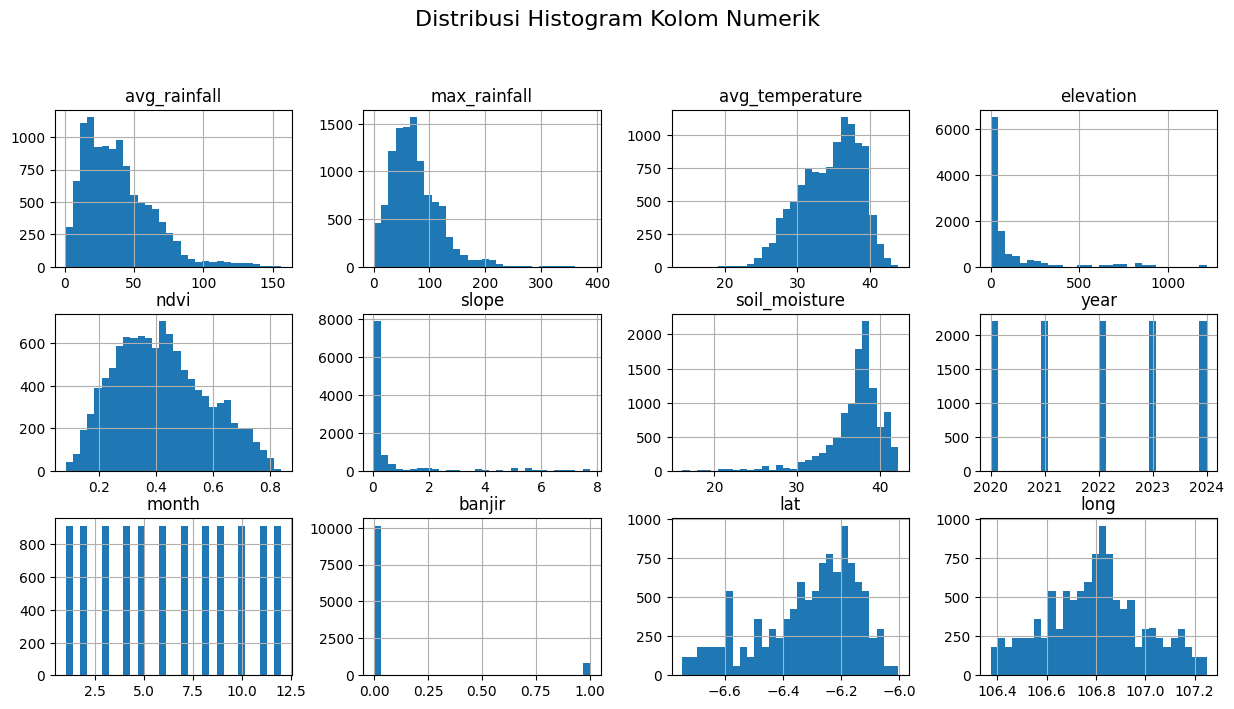

In [151]:
# Pilih hanya kolom numerik
numerical_columns = df_tabular.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram untuk setiap kolom numerik
plt.figure(figsize=(15, 10))
df_tabular[numerical_columns].hist(bins=30, figsize=(15, 10), layout=(4, 4))
plt.suptitle("Distribusi Histogram Kolom Numerik", fontsize=16)
plt.show()

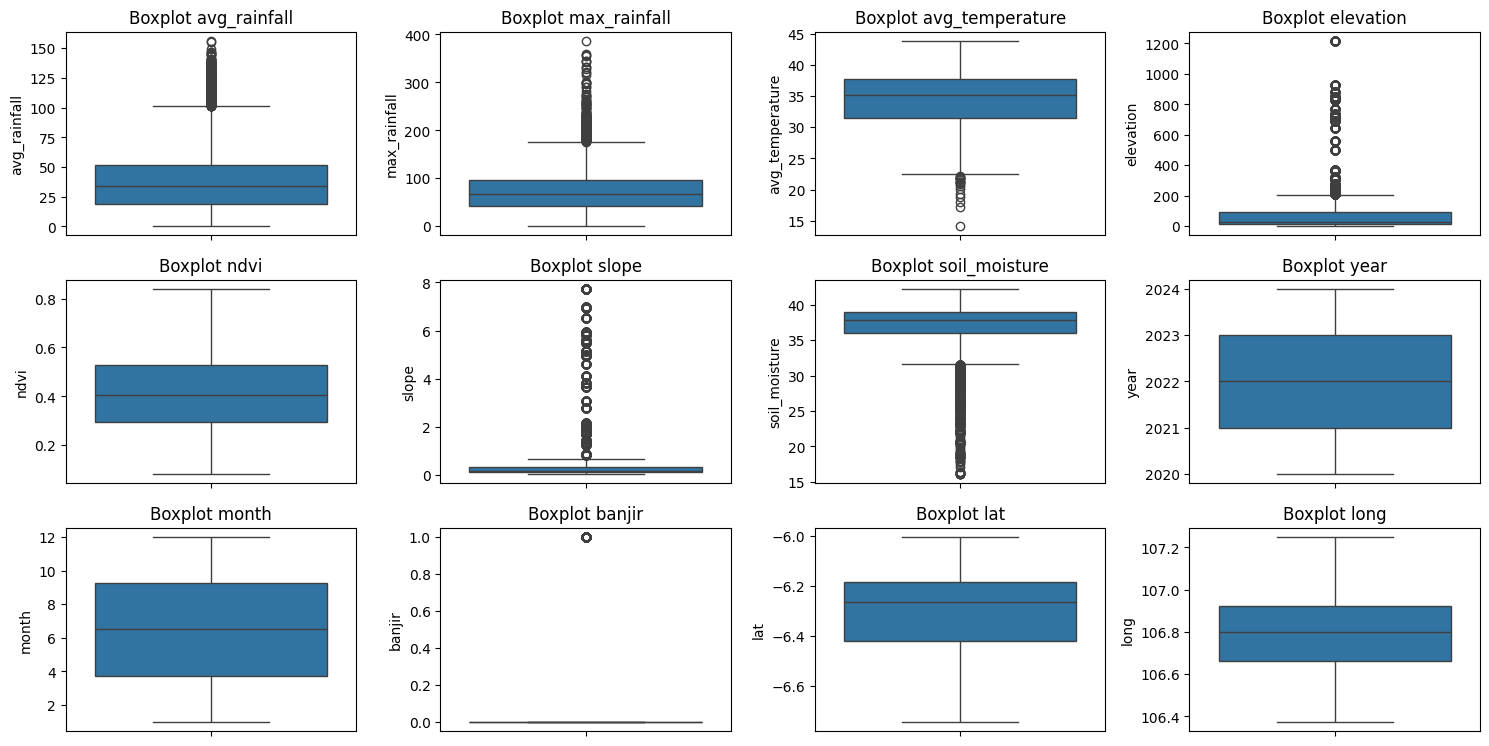

In [152]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df_tabular[col])
    plt.title(f"Boxplot {col}")
    plt.tight_layout()

plt.show()

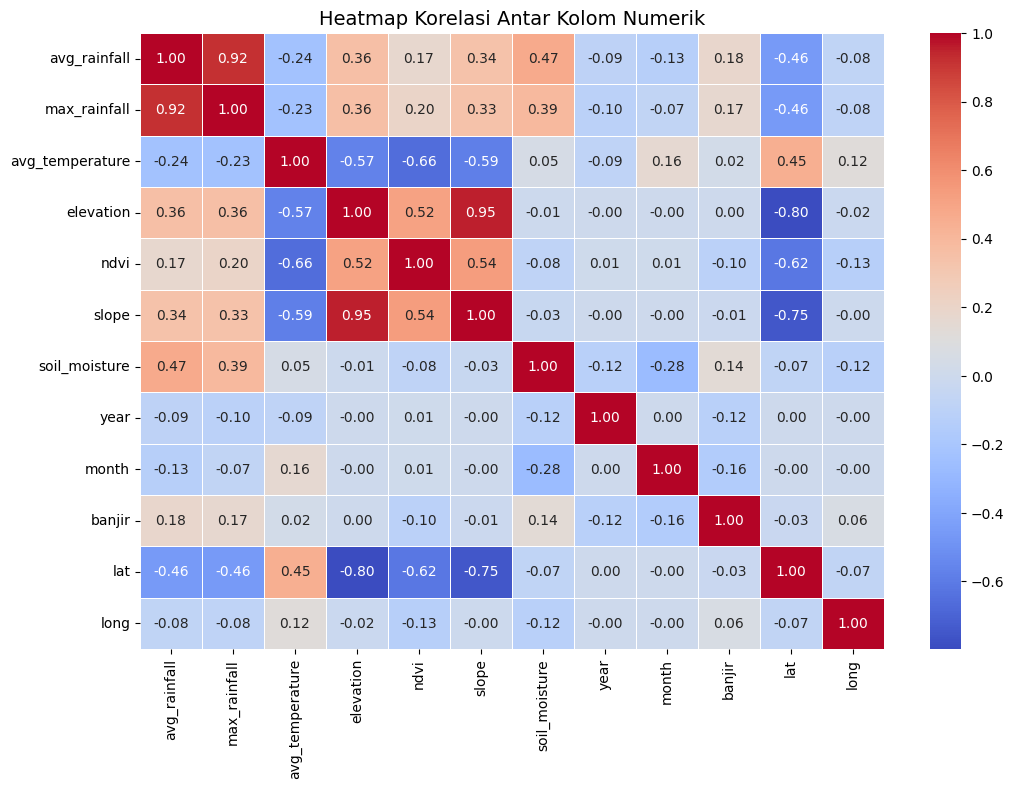

In [153]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_tabular[numerical_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Kolom Numerik", fontsize=14)
plt.show()

## Distribusi Data Kategorikal

In [154]:
categorical_columns = df_tabular.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['NAME_2', 'NAME_3', 'landcover_class', 'map_image'], dtype='object')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18720\3774204376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_tabular[col], order=df_tabular[col].value_counts().index[:10], palette="viridis")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18720\3774204376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_tabular[col], order=df_tabular[col].value_counts().index[:10], palette="viridis")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18720\3774204376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_tabular[col], order=

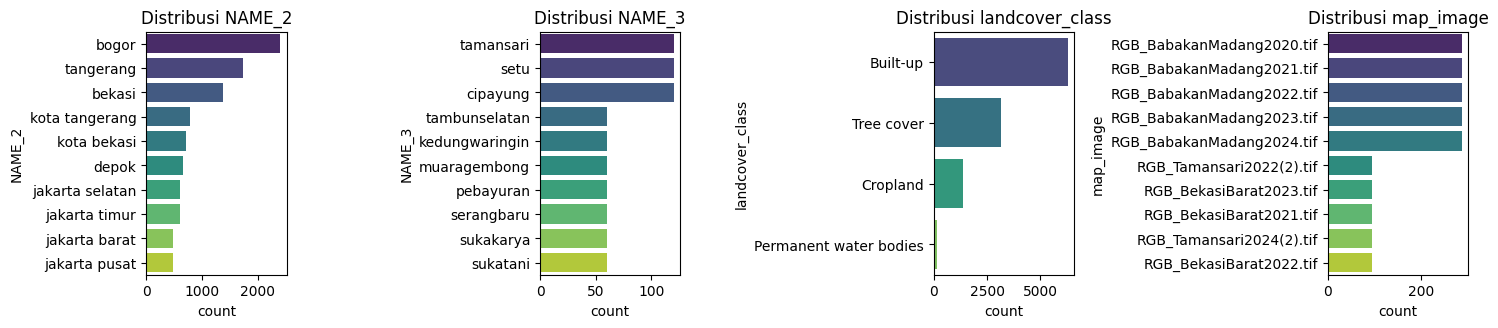

In [155]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 4, i)
    sns.countplot(y=df_tabular[col], order=df_tabular[col].value_counts().index[:10], palette="viridis")
    plt.title(f"Distribusi {col}")
    plt.tight_layout()

plt.show()

# **Data Preprocessing**

## Membersihkan outlier

In [156]:
# Kolom-kolom dengan outlier
outlier_columns = ['avg_rainfall', 'max_rainfall', 'avg_temperature',
                   'elevation', 'slope', 'soil_moisture']

# Winsorize setiap kolom (menghapus 1% bawah dan 1% atas sebagai contoh)
for col in outlier_columns:
    df_tabular[col] = winsorize(df_tabular[col], limits=[0.01, 0.01])

# Cek hasil
print(df_tabular[outlier_columns].describe())

       avg_rainfall  max_rainfall  avg_temperature     elevation  \
count  10980.000000  10980.000000     10980.000000  10980.000000   
mean      38.016063     73.307914        34.495661    110.282689   
std       24.058349     41.849802         3.995952    203.054071   
min        2.116000      3.194000        25.030000      2.309000   
25%       18.945500     42.917000        31.500000     10.470000   
50%       33.924500     67.187000        35.120000     27.206000   
75%       51.845250     96.124250        37.690000     89.403000   
max      120.654000    213.351000        41.690000    925.940000   

              slope  soil_moisture  
count  10980.000000   10980.000000  
mean       0.820279      37.077952  
std        1.653030       3.286733  
min        0.046000      23.085000  
25%        0.102000      35.982250  
50%        0.174000      37.813000  
75%        0.340000      38.932000  
max        7.714000      41.652000  


In [157]:
# Pilih hanya kolom bertipe object (kategorikal)
categorical_columns = df_tabular.select_dtypes(include=['object'])

# Hitung jumlah kategori unik di setiap kolom kategorikal
category_counts = categorical_columns.nunique()

# Tampilkan hasil
print(category_counts)

NAME_2              13
NAME_3             180
landcover_class      4
map_image          672
dtype: int64


In [158]:
onehot_cols = ['NAME_2', 'landcover_class']
label_cols = ['NAME_3']

In [159]:
# Pipeline untuk tiap tipe data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

label_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # atau bisa diganti TargetEncoder jika pakai library `category_encoders`
])

In [160]:
# Gabungkan dengan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, onehot_cols),
        ('label', label_transformer, label_cols),
    ]
)

In [161]:
# Fit-transform data tabular
X_processed = preprocessor.fit_transform(df_tabular)

# Target
y = df_tabular['banjir']

## Split Dataset

### Data Tabular

In [162]:
# Urutkan berdasarkan lokasi dan waktu
df_tabular = df_tabular.sort_values(by=['NAME_3', 'year', 'month'])

# Geser label banjir ke bulan berikutnya
df_tabular['banjir_next'] = df_tabular.groupby('NAME_3')['banjir'].shift(-1)

# Buang baris yang tidak punya target banjir_next (biasanya akhir 2024 atau akhir data)
df_tabular = df_tabular.dropna(subset=['banjir_next'])
df_tabular['banjir_next'] = df_tabular['banjir_next'].astype(int)

In [163]:
# Split berdasarkan tahun
train_data = df_tabular[df_tabular['year'] < 2024]
test_data  = df_tabular[df_tabular['year'] == 2024]


In [164]:
# Pisahkan fitur tabular dan target
X_train_raw = train_data.copy()
X_test_raw = test_data.copy()

y_train = X_train_raw['banjir_next']
y_test  = X_test_raw['banjir_next']


In [165]:
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)


### Data Gambar

In [166]:
# Ambil nama file gambar dari kolom map_image
map_train = X_train_raw["map_image"].values
map_test = X_test_raw["map_image"].values

# Load citra dari folder CITRAz_DIR
X_train_img = load_rgb_images(map_train, base_path=CITRA_DIR)
X_test_img = load_rgb_images(map_test, base_path=CITRA_DIR)

# **Modeling**

## callback

In [167]:
# Buat direktori simpan model jika belum ada
checkpoint_dir = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Path file model yang disimpan
checkpoint_path = os.path.join(checkpoint_dir, "model_multimodal_best.h5")

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

## Bangun model multimodal (CNN + MLP)

In [168]:
# === CNN untuk citra RGB satelit ===
image_input = Input(shape=(128, 128, 3), name="image_input")

x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

# === MLP untuk data tabular ===
tabular_input = Input(shape=(X_train.shape[1],), name="tabular_input")

y = Dense(128, activation='relu')(tabular_input)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)

y = Dense(64, activation='relu')(y)
y = Dropout(0.3)(y)

# === Gabungkan CNN dan MLP ===
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.4)(z)

output = Dense(1, activation='sigmoid')(z)

# === Bangun model multimodal ===
model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Opsional: Lihat ringkasan model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      3,968 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,525,185 (9.63 MB)

 Trainable params: 2,523,969 (9.63 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [169]:
history = model.fit(
    {'image_input': X_train_img, 'tabular_input': X_train},
    y_train,
    validation_data=({'image_input': X_test_img, 'tabular_input': X_test}, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8724 - loss: 0.6947
Epoch 1: val_loss improved from inf to 0.13427, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 289ms/step - accuracy: 0.8725 - loss: 0.6940 - val_accuracy: 0.9921 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9139 - loss: 0.3011
Epoch 2: val_loss improved from 0.13427 to 0.09108, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 294ms/step - accuracy: 0.9139 - loss: 0.3011 - val_accuracy: 0.9921 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9159 - loss: 0.2738
Epoch 3: val_loss did not improve from 0.09108
275/275 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.9159 - loss: 0.2738 - val_accuracy: 0.9921 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9159 - loss: 0.2675
Epoch 4: val_loss improved from 0.09108 to 0.05672, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 295ms/step - accuracy: 0.9159 - loss: 0.2675 - val_accuracy: 0.9921 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9153 - loss: 0.2698
Epoch 5: val_loss improved from 0.05672 to 0.05385, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step - accuracy: 0.9153 - loss: 0.2697 - val_accuracy: 0.9921 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9102 - loss: 0.2701
Epoch 6: val_loss improved from 0.05385 to 0.05026, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 76s 278ms/step - accuracy: 0.9102 - loss: 0.2701 - val_accuracy: 0.9921 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9137 - loss: 0.2604
Epoch 7: val_loss did not improve from 0.05026
275/275 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step - accuracy: 0.9137 - loss: 0.2604 - val_accuracy: 0.9921 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9154 - loss: 0.2613
Epoch 8: val_loss did not improve from 0.05026
275/275 ━━━━━━━━━━━━━━━━━━━━ 77s 281ms/step - accuracy: 0.9154 - loss: 0.2613 - val_accuracy: 0.9921 - val_loss: 0.0563 - learning_rate: 0.0010
Epoch 9/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9139 - loss: 0.2536
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.05026
275/275 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9139 - loss: 0.2536 - val_ac